In [1]:
# MLB API docs and tester
# http://statsapi-default-elb-prod-876255662.us-east-1.elb.amazonaws.com/docs/#!
#
# JSON viewer
# http://jsonviewer.stack.hu/
#
# https://github.com/benjamincrom/baseball#analyze-a-players-season-ra-dickey---2017
#
# https://baseballwithr.wordpress.com/2015/02/17/conceptualizing-the-mlb-strike-zone-using-pitchfx-data/


import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
%matplotlib inline

API_BASE_URL = "http://statsapi.mlb.com/api"
API_PLAYBYPLAY_URL = API_BASE_URL + "/v1/game/{}/playByPlay?fields={}"
API_SCHEDULE_URL = API_BASE_URL + "/v1/schedule?sportId=1&date={}&fields={}"
API_TEAMS_URL = API_BASE_URL + "/v1/teams?sportId=1&activeStatus=ACTIVE&fields={}"

# Team name dictionaries
TEAM_NAMES_BY_ABBREV = {}
TEAM_ABBREVS_BY_NAME = {}
TEAM_ABBREVS_BY_ID = {}

team = 'WSH'
game_date = '10/15/2019'

In [2]:
def get_data(url):
    try:
        # print('URL=', url)
        
        results = requests.get(url).json()
        if 'messageNumber' in results:
            print('ERROR:  {} - {}'.format(results['messageNumber'], results['message']))
    except:
        print('An unhandled exception occurred retrieving data from MLB.\n')
    return results


def load_teams():
    fields = 'teams,0,id,name,abbreviation'
    teams = get_data(API_TEAMS_URL.format(fields))['teams']

    # load dictionaries using specific attributes of teams
    for team in teams:
        TEAM_NAMES_BY_ABBREV.update({team['abbreviation']: team['name']})
        TEAM_ABBREVS_BY_NAME.update({team['name']: team['abbreviation']})
        TEAM_ABBREVS_BY_ID.update({team['id']: team['abbreviation']})

    return


def find_gamepk(team, game_date):
    game_pk = 0  # no game today

    try:
        # validate team names
            
        fields = 'dates,games,gamePk,teams,team,name,gameNumber'
        schedule = get_data(API_SCHEDULE_URL.format(game_date, fields))

        # loop through games looking for team
        for games in schedule['dates'][0]['games']:

            if games['teams']['away']['team']['name'] == TEAM_NAMES_BY_ABBREV[team] or \
                    games['teams']['home']['team']['name'] == TEAM_NAMES_BY_ABBREV[team]:
                game_pk = games['gamePk']
                break
    except:
        game_pk = 0  # no game found
    return game_pk
    



No traceback available to show.


In [6]:
game_pk = 0

# load team names and abbrev
load_teams()

game_pk = find_gamepk(team, game_date)
if game_pk > 0:
    fields = "allPlays,result,event,about,halfInning,playEvents,pitchData,coordinates,details,description"
    data = get_data(API_PLAYBYPLAY_URL.format(game_pk, fields))

    pitch_data_tuple = []
    for n in range(len(data['allPlays'])):
        play = data['allPlays'][n]
        inning_half = play['about']['halfInning']
        # print(inning_half)
        play_result = play['result']['event']
        # print(play_result)
        for m in range(len(play['playEvents'])):
            event = play['playEvents'][m]
            pitch_result = event['details']['description']
            if 'In play' in pitch_result:
                pitch_result = play_result
                # print(pitch_result)
            if 'pitchData' in event.keys():
                if 'x' in event['pitchData']['coordinates']:
                    x = event['pitchData']['coordinates']['x']
                    y = event['pitchData']['coordinates']['y']
                    pitch_data_tuple.append((inning_half.upper(), x, y, pitch_result))
                
pitch_data = pd.DataFrame(data=pitch_data_tuple, columns=['inning_half', 'x', 'y', 'pitch_result'])
pitch_data.head(10)


top
Strikeout
top
Strikeout
top
Strikeout
bottom
Single
Single
bottom
Double
Double
bottom
Sac Fly
Sac Fly
bottom
Double
Double
bottom
Intent Walk
bottom
Fielders Choice
Fielders Choice
bottom
Single
Single
bottom
Single
Single
bottom
Sac Bunt
Sac Bunt
bottom
Single
Single
bottom
Lineout
Lineout
top
Strikeout
top
Lineout
Lineout
top
Strikeout
bottom
Single
Single
bottom
Flyout
Flyout
bottom
Grounded Into DP
Grounded Into DP
top
Strikeout
top
Single
Single
top
Strikeout
top
Walk
top
Groundout
Groundout
bottom
Lineout
Lineout
bottom
Pop Out
Pop Out
bottom
Groundout
Groundout
top
Strikeout
top
Strikeout
top
Home Run
Home Run
top
Strikeout
bottom
Strikeout
bottom
Flyout
Flyout
bottom
Walk
bottom
Pop Out
Pop Out
top
Walk
top
Single
Single
top
Walk
top
Groundout
Groundout
top
Double
Double
top
Strikeout
top
Strikeout
bottom
Lineout
Lineout
bottom
Flyout
Flyout
bottom
Strikeout
top
Pop Out
Pop Out
top
Strikeout
top
Lineout
Lineout
bottom
Flyout
Flyout
bottom
Strikeout
bottom
Single
Single
bot

,inning_half,x,y,pitch_result
0,TOP,100.73,178.41,Called Strike
1,TOP,121.39,155.64,Swinging Strike
2,TOP,160.84,216.19,Ball
3,TOP,165.57,208.37,Foul
4,TOP,101.47,143.35,Swinging Strike
5,TOP,89.14,175.75,Swinging Strike
6,TOP,126.18,144.37,Foul
7,TOP,83.29,145.69,Swinging Strike
8,TOP,84.98,175.51,Called Strike
9,TOP,161.93,188.39,Ball


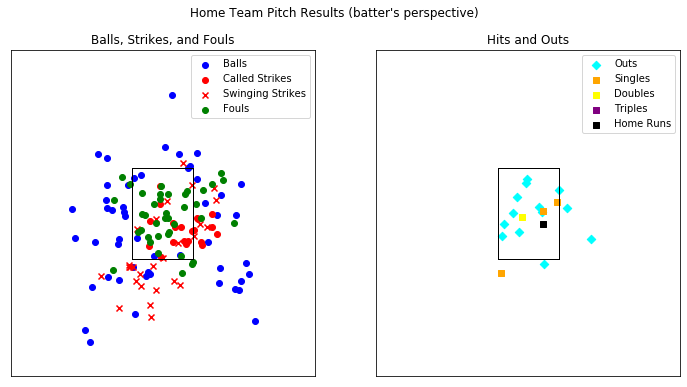

In [8]:
v_bx = [x[1] for x in pitch_data_tuple if ('BALL' in x[3].upper() and 'TOP' == x[0])]
v_by = [x[2] - 40 for x in pitch_data_tuple if ('BALL' in x[3].upper() and 'TOP' == x[0])]
v_csx = [x[1] for x in pitch_data_tuple if ('CALLED' in x[3].upper() and 'TOP' == x[0])]
v_csy = [x[2] - 40for x in pitch_data_tuple if ('CALLED' in x[3].upper() and 'TOP' == x[0])]
v_ox = [x[1] for x in pitch_data_tuple if (('OUT' in x[3].upper() or 'SAC' in x[3].upper()) and 'TOP' == x[0])]
v_oy = [x[2] - 40 for x in pitch_data_tuple if (('OUT' in x[3].upper() or 'SAC' in x[3].upper()) and 'TOP' == x[0])]
v_sx = [x[1] for x in pitch_data_tuple if ('SWINGING' in x[3].upper() and 'TOP' == x[0])]
v_sy = [x[2] - 40 for x in pitch_data_tuple if ('SWINGING' in x[3].upper() and 'TOP' == x[0])]
v_fx = [x[1] for x in pitch_data_tuple if ('FOUL' in x[3].upper() and 'TOP' == x[0])]
v_fy = [x[2] - 40 for x in pitch_data_tuple if ('FOUL' in x[3].upper() and 'TOP' == x[0])]
v_hsx = [x[1] for x in pitch_data_tuple if ('SINGLE' in x[3].upper() and 'TOP' == x[0])]
v_hsy = [x[2] -40 for x in pitch_data_tuple if ('SINGLE' in x[3].upper() and 'TOP' == x[0])]
v_hdx = [x[1] for x in pitch_data_tuple if ('DOUBLE' in x[3].upper() and 'TOP' == x[0])]
v_hdy = [x[2] -40 for x in pitch_data_tuple if ('DOUBLE' in x[3].upper() and 'TOP' == x[0])]
v_htx = [x[1] for x in pitch_data_tuple if ('TRIPLE' in x[3].upper() and 'TOP' == x[0])]
v_hty = [x[2] -40 for x in pitch_data_tuple if ('TRIPLE' in x[3].upper() and 'TOP' == x[0])]
v_hhx = [x[1] for x in pitch_data_tuple if ('HOME' in x[3].upper() and 'TOP' == x[0])]
v_hhy = [x[2] - 40 for x in pitch_data_tuple if ('HOME' in x[3].upper() and 'TOP' == x[0])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.0,6.0))
fig.suptitle('Home Team Pitch Results (batter\'s perspective)')

ax1.set_ylim(250, 0)
ax1.set_xlim(250, 0)
ax1.set_title('Balls, Strikes, and Fouls')

# plot pitches
v_balls = ax1.scatter(v_bx, v_by, color='blue', label='Balls')
v_called_strikes = ax1.scatter(v_csx, v_csy, color='red', label='Called Strikes')
v_strikes = ax1.scatter(v_sx, v_sy, marker='x', color='red', label='Swinging Strikes')
v_fouls = ax1.scatter(v_fx, v_fy, color='green', label = 'Fouls')
ax1.legend()
ax1.set_xticks(())
ax1.set_yticks(())

# mark strike zone -- just made up
ax1.plot([100, 150], [90, 90], color='black', linestyle='-', linewidth=1)
ax1.plot([100, 150], [160, 160], color='black', linestyle='-', linewidth=1)
ax1.plot([100, 100], [90, 160], color='black', linestyle='-', linewidth=1)
ax1.plot([150, 150], [90, 160], color='black', linestyle='-', linewidth=1)

ax2.set_ylim(250, 0)
ax2.set_xlim(250, 0)
ax2.set_title('Hits and Outs')

v_outs = ax2.scatter(v_ox, v_oy, marker='D', color='cyan', label='Outs')
v_singles = ax2.scatter(v_hsx, v_hsy, marker='s', color='orange', label='Singles')
v_doubles = ax2.scatter(v_hdx, v_hdy, marker='s', color='yellow', label='Doubles')
v_triples = ax2.scatter(v_htx, v_hty, marker='s', color='purple', label='Triples')
v_homers = ax2.scatter(v_hhx, v_hhy, marker='s', color='black', label='Home Runs')
ax2.legend()
ax2.set_xticks(())
ax2.set_yticks(())

# mark strike zone -- just made up
ax2.plot([100, 150], [90, 90], color='black', linestyle='-', linewidth=1)
ax2.plot([100, 150], [160, 160], color='black', linestyle='-', linewidth=1)
ax2.plot([100, 100], [90, 160], color='black', linestyle='-', linewidth=1)
ax2.plot([150, 150], [90, 160], color='black', linestyle='-', linewidth=1)

# display
plt.show()

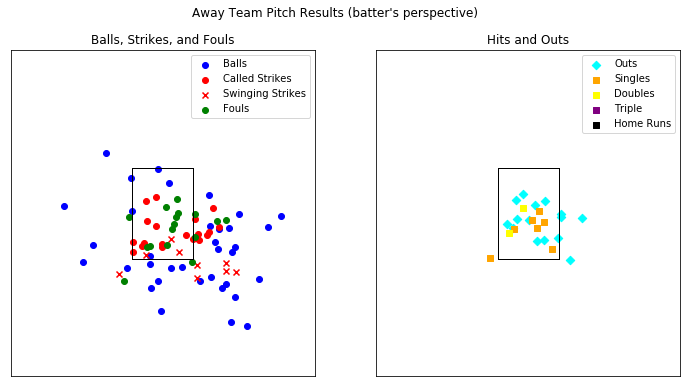

In [7]:
h_bx = [x[1] for x in pitch_data_tuple if ('BALL' in x[3].upper() and 'BOTTOM' == x[0])]
h_by = [x[2] - 40 for x in pitch_data_tuple if ('BALL' in x[3].upper() and 'BOTTOM' == x[0])]
h_csx = [x[1] for x in pitch_data_tuple if ('CALLED' in x[3].upper() and 'BOTTOM' == x[0])]
h_csy = [x[2] - 40for x in pitch_data_tuple if ('CALLED' in x[3].upper() and 'BOTTOM' == x[0])]
h_ox = [x[1] for x in pitch_data_tuple if (('OUT' in x[3].upper() or 'SAC' in x[3].upper()) and 'BOTTOM' == x[0])]
h_oy = [x[2] - 40 for x in pitch_data_tuple if (('OUT' in x[3].upper() or 'SAC' in x[3].upper()) and 'BOTTOM' == x[0])]
h_sx = [x[1] for x in pitch_data_tuple if ('SWINGING' in x[3].upper() and 'BOTTOM' == x[0])]
h_sy = [x[2] - 40 for x in pitch_data_tuple if ('SWINGING' in x[3].upper() and 'BOTTOM' == x[0])]
h_fx = [x[1] for x in pitch_data_tuple if ('FOUL' in x[3].upper() and 'BOTTOM' == x[0])]
h_fy = [x[2] - 40 for x in pitch_data_tuple if ('FOUL' in x[3].upper() and 'BOTTOM' == x[0])]
h_hsx = [x[1] for x in pitch_data_tuple if ('SINGLE' in x[3].upper() and 'BOTTOM' == x[0])]
h_hsy = [x[2] -40 for x in pitch_data_tuple if ('SINGLE' in x[3].upper() and 'BOTTOM' == x[0])]
h_hdx = [x[1] for x in pitch_data_tuple if ('DOUBLE' in x[3].upper() and 'BOTTOM' == x[0])]
h_hdy = [x[2] -40 for x in pitch_data_tuple if ('DOUBLE' in x[3].upper() and 'BOTTOM' == x[0])]
h_htx = [x[1] for x in pitch_data_tuple if ('TRIPLE' in x[3].upper() and 'BOTTOM' == x[0])]
h_hty = [x[2] -40 for x in pitch_data_tuple if ('TRIPLE' in x[3].upper() and 'BOTTOM' == x[0])]
h_hhx = [x[1] for x in pitch_data_tuple if ('HOME' in x[3].upper() and 'BOTTOM' == x[0])]
h_hhy = [x[2] - 40 for x in pitch_data_tuple if ('HOME' in x[3].upper() and 'BOTTOM' == x[0])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.0,6.0))
fig.suptitle('Away Team Pitch Results (batter\'s perspective)')

ax1.set_ylim(250, 0)
ax1.set_xlim(250, 0)
ax1.set_title('Balls, Strikes, and Fouls')

# plot pitches
h_balls = ax1.scatter(h_bx, h_by, color='blue', label='Balls')
h_called_strikes = ax1.scatter(h_csx, h_csy, color='red', label='Called Strikes')
h_strikes = ax1.scatter(h_sx, h_sy, marker='x', color='red', label='Swinging Strikes')
h_fouls = ax1.scatter(h_fx, h_fy, color='green', label='Fouls')
ax1.legend()
ax1.set_xticks(())
ax1.set_yticks(())

# mark strike zone -- just made up
ax1.plot([100, 150], [90, 90], color='black', linestyle='-', linewidth=1)
ax1.plot([100, 150], [160, 160], color='black', linestyle='-', linewidth=1)
ax1.plot([100, 100], [90, 160], color='black', linestyle='-', linewidth=1)
ax1.plot([150, 150], [90, 160], color='black', linestyle='-', linewidth=1)

ax2.set_ylim(250, 0)
ax2.set_xlim(250, 0)
ax2.set_title('Hits and Outs')

h_outs = ax2.scatter(h_ox, h_oy, marker='D', color='cyan', label='Outs')
h_singles = ax2.scatter(h_hsx, h_hsy, marker='s', color='orange', label='Singles')
h_doubles = ax2.scatter(h_hdx, h_hdy, marker='s', color='yellow', label='Doubles')
h_triples = ax2.scatter(h_htx, h_hty, marker='s', color='purple', label='Triple')
h_homers = ax2.scatter(h_hhx, h_hhy, marker='s', color='black', label='Home Runs')

ax2.legend()
ax2.set_xticks(())
ax2.set_yticks(())

# mark strike zone -- just made up
ax2.plot([100, 150], [90, 90], color='black', linestyle='-', linewidth=1)
ax2.plot([100, 150], [160, 160], color='black', linestyle='-', linewidth=1)
ax2.plot([100, 100], [90, 160], color='black', linestyle='-', linewidth=1)
ax2.plot([150, 150], [90, 160], color='black', linestyle='-', linewidth=1)

# display
plt.show()